In [1]:
# coding=utf-8
# Copyright 2018 The OpenAI Team Authors and HuggingFace Inc. team.
# Copyright (c) 2018, NVIDIA CORPORATION.  All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""PyTorch OpenAI GPT-2 model."""

import math
import os
from dataclasses import dataclass
from typing import Optional, Tuple

import torch
import torch.utils.checkpoint
from packaging import version
from torch import nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss


if version.parse(torch.__version__) >= version.parse("1.6"):
    is_amp_available = True
    from torch.cuda.amp import autocast
else:
    is_amp_available = False

from transformers.activations import ACT2FN
from transformers.file_utils import (
    ModelOutput,
    add_code_sample_docstrings,
    add_start_docstrings,
    add_start_docstrings_to_model_forward,
    replace_return_docstrings,
)
from transformers.modeling_outputs import (
    BaseModelOutputWithPastAndCrossAttentions,
    CausalLMOutputWithCrossAttentions,
    SequenceClassifierOutputWithPast,
    TokenClassifierOutput,
)
from transformers.modeling_utils import (
    Conv1D,
    PreTrainedModel,
    SequenceSummary,
    find_pruneable_heads_and_indices,
    prune_conv1d_layer,
)
from transformers.utils import logging
from transformers.models.gpt2.configuration_gpt2 import GPT2Config


logger = logging.get_logger(__name__)

_CHECKPOINT_FOR_DOC = "gpt2"
_CONFIG_FOR_DOC = "GPT2Config"
_TOKENIZER_FOR_DOC = "GPT2Tokenizer"

GPT2_PRETRAINED_MODEL_ARCHIVE_LIST = [
    "gpt2",
    "gpt2-medium",
    "gpt2-large",
    "gpt2-xl",
    "distilgpt2",
    # See all GPT-2 models at https://huggingface.co/models?filter=gpt2
]


def load_tf_weights_in_gpt2(model, config, gpt2_checkpoint_path):
    """Load tf checkpoints in a pytorch model"""
    try:
        import re

        import tensorflow as tf
    except ImportError:
        logger.error(
            "Loading a TensorFlow model in PyTorch, requires TensorFlow to be installed. Please see "
            "https://www.tensorflow.org/install/ for installation instructions."
        )
        raise
    tf_path = os.path.abspath(gpt2_checkpoint_path)
    logger.info(f"Converting TensorFlow checkpoint from {tf_path}")
    # Load weights from TF model
    init_vars = tf.train.list_variables(tf_path)
    names = []
    arrays = []
    for name, shape in init_vars:
        logger.info(f"Loading TF weight {name} with shape {shape}")
        array = tf.train.load_variable(tf_path, name)
        names.append(name)
        arrays.append(array.squeeze())

    for name, array in zip(names, arrays):
        name = name[6:]  # skip "model/"
        name = name.split("/")
        pointer = model
        for m_name in name:
            if re.fullmatch(r"[A-Za-z]+\d+", m_name):
                scope_names = re.split(r"(\d+)", m_name)
            else:
                scope_names = [m_name]
            if scope_names[0] == "w" or scope_names[0] == "g":
                pointer = getattr(pointer, "weight")
            elif scope_names[0] == "b":
                pointer = getattr(pointer, "bias")
            elif scope_names[0] == "wpe" or scope_names[0] == "wte":
                pointer = getattr(pointer, scope_names[0])
                pointer = getattr(pointer, "weight")
            else:
                pointer = getattr(pointer, scope_names[0])
            if len(scope_names) >= 2:
                num = int(scope_names[1])
                pointer = pointer[num]
        try:
            assert (
                pointer.shape == array.shape
            ), f"Pointer shape {pointer.shape} and array shape {array.shape} mismatched"
        except AssertionError as e:
            e.args += (pointer.shape, array.shape)
            raise
        logger.info(f"Initialize PyTorch weight {name}")
        pointer.data = torch.from_numpy(array)
    return model


class GPT2Attention(nn.Module):
    def __init__(self, config, is_cross_attention=False, layer_idx=None):
        super().__init__()

        max_positions = config.max_position_embeddings
        self.register_buffer(
            "bias",
            torch.tril(torch.ones((max_positions, max_positions), dtype=torch.uint8)).view(
                1, 1, max_positions, max_positions
            ),
        )
        self.register_buffer("masked_bias", torch.tensor(-1e4))

        self.embed_dim = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.head_dim = self.embed_dim // self.num_heads
        self.split_size = self.embed_dim
        if self.head_dim * self.num_heads != self.embed_dim:
            raise ValueError(
                f"`embed_dim` must be divisible by num_heads (got `embed_dim`: {self.embed_dim} and `num_heads`: {self.num_heads})."
            )

        self.scale_attn_weights = config.scale_attn_weights
        self.is_cross_attention = is_cross_attention

        # Layer-wise attention scaling, reordering, and upcasting
        self.scale_attn_by_inverse_layer_idx = config.scale_attn_by_inverse_layer_idx
        self.layer_idx = layer_idx
        self.reorder_and_upcast_attn = config.reorder_and_upcast_attn

        if self.is_cross_attention:
            self.c_attn = Conv1D(2 * self.embed_dim, self.embed_dim)
            self.q_attn = Conv1D(self.embed_dim, self.embed_dim)
        else:
            self.c_attn = Conv1D(3 * self.embed_dim, self.embed_dim)
        self.c_proj = Conv1D(self.embed_dim, self.embed_dim)

        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)

    def _attn(self, query, key, value, attention_mask=None, head_mask=None):
        attn_weights = torch.matmul(query, key.transpose(-1, -2))

        if self.scale_attn_weights:
            attn_weights = attn_weights / (value.size(-1) ** 0.5)

        # Layer-wise attention scaling
        if self.scale_attn_by_inverse_layer_idx:
            attn_weights = attn_weights / float(self.layer_idx + 1)

        if not self.is_cross_attention:
            # if only "normal" attention layer implements causal mask
            query_length, key_length = query.size(-2), key.size(-2)
            causal_mask = self.bias[:, :, key_length - query_length : key_length, :key_length].bool()
            attn_weights = torch.where(causal_mask, attn_weights, self.masked_bias.to(attn_weights.dtype))

        if attention_mask is not None:
            # Apply the attention mask
            attn_weights = attn_weights + attention_mask

        attn_weights = nn.functional.softmax(attn_weights, dim=-1)

        # Downcast (if necessary) back to V's dtype (if in mixed-precision) -- No-Op otherwise
        attn_weights = attn_weights.type(value.dtype)
        attn_weights = self.attn_dropout(attn_weights)

        # Mask heads if we want to
        if head_mask is not None:
            attn_weights = attn_weights * head_mask

        attn_output = torch.matmul(attn_weights, value)

        return attn_output, attn_weights

    def _upcast_and_reordered_attn(self, query, key, value, attention_mask=None, head_mask=None):
        # Use `torch.baddbmm` (a bit more efficient w/ alpha param for scaling -- from Megatron-LM)
        bsz, num_heads, q_seq_len, dk = query.size()
        _, _, k_seq_len, _ = key.size()

        # Preallocate attn_weights for `baddbmm`
        attn_weights = torch.empty(bsz * num_heads, q_seq_len, k_seq_len, dtype=torch.float32, device=query.device)

        # Compute Scale Factor
        scale_factor = 1.0
        if self.scale_attn_weights:
            scale_factor /= float(value.size(-1)) ** 0.5

        if self.scale_attn_by_inverse_layer_idx:
            scale_factor /= float(self.layer_idx + 1)

        # Upcast (turn off autocast) and reorder (Scale K by 1 / root(dk))
        q, k = query.reshape(-1, q_seq_len, dk), key.transpose(-1, -2).reshape(-1, dk, k_seq_len)
        attn_weights = torch.baddbmm(attn_weights, q.float(), k.float(), beta=0, alpha=scale_factor)
        attn_weights = attn_weights.reshape(bsz, num_heads, q_seq_len, k_seq_len)

        if not self.is_cross_attention:
            # if only "normal" attention layer implements causal mask
            query_length, key_length = query.size(-2), key.size(-2)
            causal_mask = self.bias[:, :, key_length - query_length : key_length, :key_length].bool()
            attn_weights = torch.where(causal_mask, attn_weights, self.masked_bias.to(attn_weights.dtype))

        if attention_mask is not None:
            # Apply the attention mask
            attn_weights = attn_weights + attention_mask

        attn_weights = nn.functional.softmax(attn_weights, dim=-1)

        # Downcast (if necessary) back to V's dtype (if in mixed-precision) -- No-Op if otherwise
        if attn_weights.dtype != torch.float32:
            raise RuntimeError("Error with upcasting, attn_weights does not have dtype torch.float32")
        attn_weights = attn_weights.type(value.dtype)
        attn_weights = self.attn_dropout(attn_weights)

        # Mask heads if we want to
        if head_mask is not None:
            attn_weights = attn_weights * head_mask

        attn_output = torch.matmul(attn_weights, value)

        return attn_output, attn_weights

    def _split_heads(self, tensor, num_heads, attn_head_size):
        """
        Splits hidden_size dim into attn_head_size and num_heads
        """
        new_shape = tensor.size()[:-1] + (num_heads, attn_head_size)
        tensor = tensor.view(new_shape)
        return tensor.permute(0, 2, 1, 3)  # (batch, head, seq_length, head_features)

    def _merge_heads(self, tensor, num_heads, attn_head_size):
        """
        Merges attn_head_size dim and num_attn_heads dim into hidden_size
        """
        tensor = tensor.permute(0, 2, 1, 3).contiguous()
        new_shape = tensor.size()[:-2] + (num_heads * attn_head_size,)
        return tensor.view(new_shape)

    def forward(
        self,
        hidden_states,
        layer_past=None,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        use_cache=False,
        output_attentions=False,
    ):
        if encoder_hidden_states is not None:
            if not hasattr(self, "q_attn"):
                raise ValueError(
                    "If class is used as cross attention, the weights `q_attn` have to be defined. "
                    "Please make sure to instantiate class with `GPT2Attention(..., is_cross_attention=True)`."
                )

            query = self.q_attn(hidden_states)
            key, value = self.c_attn(encoder_hidden_states).split(self.split_size, dim=2)
            attention_mask = encoder_attention_mask
        else:
            query, key, value = self.c_attn(hidden_states).split(self.split_size, dim=2)

        query = self._split_heads(query, self.num_heads, self.head_dim)
        key = self._split_heads(key, self.num_heads, self.head_dim)
        value = self._split_heads(value, self.num_heads, self.head_dim)

        if layer_past is not None:
            past_key, past_value = layer_past
            key = torch.cat((past_key, key), dim=-2)
            value = torch.cat((past_value, value), dim=-2)

        if use_cache is True:
            present = (key, value)
        else:
            present = None

        if self.reorder_and_upcast_attn:
            attn_output, attn_weights = self._upcast_and_reordered_attn(query, key, value, attention_mask, head_mask)
        else:
            attn_output, attn_weights = self._attn(query, key, value, attention_mask, head_mask)

        attn_output = self._merge_heads(attn_output, self.num_heads, self.head_dim)
        attn_output = self.c_proj(attn_output)
        attn_output = self.resid_dropout(attn_output)

        outputs = (attn_output, present)
        if output_attentions:
            outputs += (attn_weights,)

        return outputs  # a, present, (attentions)


class GPT2MLP(nn.Module):
    def __init__(self, intermediate_size, config):
        super().__init__()
        embed_dim = config.hidden_size
        self.c_fc = Conv1D(intermediate_size, embed_dim)
        self.c_proj = Conv1D(embed_dim, intermediate_size)
        self.act = ACT2FN[config.activation_function]
        self.dropout = nn.Dropout(config.resid_pdrop)

    def forward(self, hidden_states):
        hidden_states = self.c_fc(hidden_states)
        hidden_states = self.act(hidden_states)
        hidden_states = self.c_proj(hidden_states)
        hidden_states = self.dropout(hidden_states)
        return hidden_states


class GPT2Block(nn.Module):
    def __init__(self, config, layer_idx=None):
        super().__init__()
        hidden_size = config.hidden_size
        inner_dim = config.n_inner if config.n_inner is not None else 4 * hidden_size

        self.ln_1 = nn.LayerNorm(hidden_size, eps=config.layer_norm_epsilon)
        self.attn = GPT2Attention(config, layer_idx=layer_idx)
        self.ln_2 = nn.LayerNorm(hidden_size, eps=config.layer_norm_epsilon)

        if config.add_cross_attention:
            self.crossattention = GPT2Attention(config, is_cross_attention=True, layer_idx=layer_idx)
            self.ln_cross_attn = nn.LayerNorm(hidden_size, eps=config.layer_norm_epsilon)

        self.mlp = GPT2MLP(inner_dim, config)

    def forward(
        self,
        hidden_states,
        layer_past=None,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        use_cache=False,
        output_attentions=False,
    ):
        residual = hidden_states
        hidden_states = self.ln_1(hidden_states)
        attn_outputs = self.attn(
            hidden_states,
            layer_past=layer_past,
            attention_mask=attention_mask,
            head_mask=head_mask,
            use_cache=use_cache,
            output_attentions=output_attentions,
        )
        attn_output = attn_outputs[0]  # output_attn: a, present, (attentions)
        outputs = attn_outputs[1:]
        # residual connection
        hidden_states = attn_output + residual

        if encoder_hidden_states is not None:
            # add one self-attention block for cross-attention
            if not hasattr(self, "crossattention"):
                raise ValueError(
                    f"If `encoder_hidden_states` are passed, {self} has to be instantiated with "
                    "cross-attention layers by setting `config.add_cross_attention=True`"
                )
            residual = hidden_states
            hidden_states = self.ln_cross_attn(hidden_states)
            cross_attn_outputs = self.crossattention(
                hidden_states,
                attention_mask=attention_mask,
                head_mask=head_mask,
                encoder_hidden_states=encoder_hidden_states,
                encoder_attention_mask=encoder_attention_mask,
                output_attentions=output_attentions,
            )
            attn_output = cross_attn_outputs[0]
            # residual connection
            hidden_states = residual + attn_output
            outputs = outputs + cross_attn_outputs[2:]  # add cross attentions if we output attention weights

        residual = hidden_states
        hidden_states = self.ln_2(hidden_states)
        feed_forward_hidden_states = self.mlp(hidden_states)
        # residual connection
        hidden_states = residual + feed_forward_hidden_states

        if use_cache:
            outputs = (hidden_states,) + outputs
        else:
            outputs = (hidden_states,) + outputs[1:]

        return outputs  # hidden_states, present, (attentions, cross_attentions)


class GPT2PreTrainedModel(PreTrainedModel):
    """
    An abstract class to handle weights initialization and a simple interface for downloading and loading pretrained
    models.
    """

    config_class = GPT2Config
    load_tf_weights = load_tf_weights_in_gpt2
    base_model_prefix = "transformer"

    def __init__(self, *inputs, **kwargs):
        super().__init__(*inputs, **kwargs)

    def _init_weights(self, module):
        """Initialize the weights."""
        if isinstance(module, (nn.Linear, Conv1D)):
            # Slightly different from the TF version which uses truncated_normal for initialization
            # cf https://github.com/pytorch/pytorch/pull/5617
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

        # Reinitialize selected weights subject to the OpenAI GPT-2 Paper Scheme:
        #   > A modified initialization which accounts for the accumulation on the residual path with model depth. Scale
        #   > the weights of residual layers at initialization by a factor of 1/√N where N is the # of residual layers.
        #   >   -- GPT-2 :: https://openai.com/blog/better-language-models/
        #
        # Reference (Megatron-LM): https://github.com/NVIDIA/Megatron-LM/blob/main/megatron/model/gpt_model.py
        for name, p in module.named_parameters():
            if "c_proj" in name and "weight" in name:
                # Special Scaled Initialization --> There are 2 Layer Norms per Transformer Block
                p.data.normal_(mean=0.0, std=(self.config.initializer_range / math.sqrt(2 * self.config.n_layer)))



class GPT2Model(GPT2PreTrainedModel):
    _keys_to_ignore_on_load_missing = ["attn.masked_bias"]

    def __init__(self, config):
        super().__init__(config)

        self.embed_dim = config.hidden_size

        self.wte = nn.Embedding(config.vocab_size, self.embed_dim)
        self.wpe = nn.Embedding(config.max_position_embeddings, self.embed_dim)

        self.drop = nn.Dropout(config.embd_pdrop)
        self.h = nn.ModuleList([GPT2Block(config, layer_idx=i) for i in range(config.num_hidden_layers)])
        self.ln_f = nn.LayerNorm(self.embed_dim, eps=config.layer_norm_epsilon)

        # Initialize weights and apply final processing
        self.post_init()


    def get_input_embeddings(self):
        return self.wte

    def set_input_embeddings(self, new_embeddings):
        self.wte = new_embeddings

    def forward(
        self,
        input_ids=None,
        past_key_values=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        use_cache = use_cache if use_cache is not None else self.config.use_cache
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
        elif input_ids is not None:
            input_shape = input_ids.size()
            input_ids = input_ids.view(-1, input_shape[-1])
            batch_size = input_ids.shape[0]
        elif inputs_embeds is not None:
            input_shape = inputs_embeds.size()[:-1]
            batch_size = inputs_embeds.shape[0]
        else:
            raise ValueError("You have to specify either input_ids or inputs_embeds")

        device = input_ids.device if input_ids is not None else inputs_embeds.device

        if token_type_ids is not None:
            token_type_ids = token_type_ids.view(-1, input_shape[-1])
        if position_ids is not None:
            position_ids = position_ids.view(-1, input_shape[-1])

        if past_key_values is None:
            past_length = 0
            past_key_values = tuple([None] * len(self.h))
        else:
            past_length = past_key_values[0][0].size(-2)
        if position_ids is None:
            position_ids = torch.arange(past_length, input_shape[-1] + past_length, dtype=torch.long, device=device)
            position_ids = position_ids.unsqueeze(0).view(-1, input_shape[-1])

        # GPT2Attention mask.
        if attention_mask is not None:
            if batch_size <= 0:
                raise ValueError("batch_size has to be defined and > 0")
            attention_mask = attention_mask.view(batch_size, -1)
            # We create a 3D attention mask from a 2D tensor mask.
            # Sizes are [batch_size, 1, 1, to_seq_length]
            # So we can broadcast to [batch_size, num_heads, from_seq_length, to_seq_length]
            # this attention mask is more simple than the triangular masking of causal attention
            # used in OpenAI GPT, we just need to prepare the broadcast dimension here.
            attention_mask = attention_mask[:, None, None, :]

            # Since attention_mask is 1.0 for positions we want to attend and 0.0 for
            # masked positions, this operation will create a tensor which is 0.0 for
            # positions we want to attend and -10000.0 for masked positions.
            # Since we are adding it to the raw scores before the softmax, this is
            # effectively the same as removing these entirely.
            attention_mask = attention_mask.to(dtype=self.dtype)  # fp16 compatibility
            attention_mask = (1.0 - attention_mask) * -10000.0

        # If a 2D or 3D attention mask is provided for the cross-attention
        # we need to make broadcastable to [batch_size, num_heads, seq_length, seq_length]
        if self.config.add_cross_attention and encoder_hidden_states is not None:
            encoder_batch_size, encoder_sequence_length, _ = encoder_hidden_states.size()
            encoder_hidden_shape = (encoder_batch_size, encoder_sequence_length)
            if encoder_attention_mask is None:
                encoder_attention_mask = torch.ones(encoder_hidden_shape, device=device)
            encoder_attention_mask = self.invert_attention_mask(encoder_attention_mask)
        else:
            encoder_attention_mask = None

        # Prepare head mask if needed
        # 1.0 in head_mask indicate we keep the head
        # attention_probs has shape bsz x n_heads x N x N
        # head_mask has shape n_layer x batch x n_heads x N x N
        head_mask = self.get_head_mask(head_mask, self.config.n_layer)

        if inputs_embeds is None:
            inputs_embeds = self.wte(input_ids)
        position_embeds = self.wpe(position_ids)
        hidden_states = inputs_embeds + position_embeds

        if token_type_ids is not None:
            token_type_embeds = self.wte(token_type_ids)
            hidden_states = hidden_states + token_type_embeds

        hidden_states = self.drop(hidden_states)

        output_shape = input_shape + (hidden_states.size(-1),)

        presents = () if use_cache else None
        all_self_attentions = () if output_attentions else None
        all_cross_attentions = () if output_attentions and self.config.add_cross_attention else None
        all_hidden_states = () if output_hidden_states else None
        for i, (block, layer_past) in enumerate(zip(self.h, past_key_values)):
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            outputs = block(
                hidden_states,
                layer_past=layer_past,
                attention_mask=attention_mask,
                head_mask=head_mask[i],
                encoder_hidden_states=encoder_hidden_states,
                encoder_attention_mask=encoder_attention_mask,
                use_cache=use_cache,
                output_attentions=output_attentions,
            )

            hidden_states = outputs[0]
            if use_cache is True:
                presents = presents + (outputs[1],)

            if output_attentions:
                all_self_attentions = all_self_attentions + (outputs[2 if use_cache else 1],)
                if self.config.add_cross_attention:
                    all_cross_attentions = all_cross_attentions + (outputs[3 if use_cache else 2],)

        hidden_states = self.ln_f(hidden_states)

        hidden_states = hidden_states.view(output_shape)
        # Add last hidden state
        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:
            return tuple(
                v
                for v in [hidden_states, presents, all_hidden_states, all_self_attentions, all_cross_attentions]
                if v is not None
            )

        return BaseModelOutputWithPastAndCrossAttentions(
            last_hidden_state=hidden_states,
            past_key_values=presents,
            hidden_states=all_hidden_states,
            attentions=all_self_attentions,
            cross_attentions=all_cross_attentions,
        )

class GPT2LMHeadModel(GPT2PreTrainedModel):
    _keys_to_ignore_on_load_missing = [r"attn.masked_bias", r"attn.bias", r"lm_head.weight"]

    def __init__(self, config):
        super().__init__(config)
        self.transformer = GPT2Model(config)
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # Initialize weights and apply final processing
        self.post_init()

    def get_output_embeddings(self):
        return self.lm_head

    def set_output_embeddings(self, new_embeddings):
        self.lm_head = new_embeddings

    def prepare_inputs_for_generation(self, input_ids, past=None, **kwargs):
        token_type_ids = kwargs.get("token_type_ids", None)
        # only last token for inputs_ids if past is defined in kwargs
        if past:
            input_ids = input_ids[:, -1].unsqueeze(-1)
            if token_type_ids is not None:
                token_type_ids = token_type_ids[:, -1].unsqueeze(-1)

        attention_mask = kwargs.get("attention_mask", None)
        position_ids = kwargs.get("position_ids", None)

        if attention_mask is not None and position_ids is None:
            # create position_ids on the fly for batch generation
            position_ids = attention_mask.long().cumsum(-1) - 1
            position_ids.masked_fill_(attention_mask == 0, 1)
            if past:
                position_ids = position_ids[:, -1].unsqueeze(-1)
        else:
            position_ids = None
        return {
            "input_ids": input_ids,
            "past_key_values": past,
            "use_cache": kwargs.get("use_cache"),
            "position_ids": position_ids,
            "attention_mask": attention_mask,
            "token_type_ids": token_type_ids,
        }

    def forward(
        self,
        input_ids=None,
        past_key_values=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        labels=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        labels (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
            Labels for language modeling. Note that the labels **are shifted** inside the model, i.e. you can set
            `labels = input_ids` Indices are selected in `[-100, 0, ..., config.vocab_size]` All labels set to `-100`
            are ignored (masked), the loss is only computed for labels in `[0, ..., config.vocab_size]`
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        transformer_outputs = self.transformer(
            input_ids,
            past_key_values=past_key_values,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_attention_mask,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = transformer_outputs[0]

        lm_logits = self.lm_head(hidden_states)

        loss = None
        if labels is not None:
            # Shift so that tokens < n predict n
            shift_logits = lm_logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()
            # Flatten the tokens
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

        if not return_dict:
            output = (lm_logits,) + transformer_outputs[1:]
            return ((loss,) + output) if loss is not None else output

        return CausalLMOutputWithCrossAttentions(
            loss=loss,
            logits=lm_logits,
            past_key_values=transformer_outputs.past_key_values,
            hidden_states=transformer_outputs.hidden_states,
            attentions=transformer_outputs.attentions,
            cross_attentions=transformer_outputs.cross_attentions,
        )

    @staticmethod
    def _reorder_cache(past: Tuple[Tuple[torch.Tensor]], beam_idx: torch.Tensor) -> Tuple[Tuple[torch.Tensor]]:
        """
        This function is used to re-order the `past_key_values` cache if [`~PreTrainedModel.beam_search`] or
        [`~PreTrainedModel.beam_sample`] is called. This is required to match `past_key_values` with the correct
        beam_idx at every generation step.
        """
        return tuple(
            tuple(past_state.index_select(0, beam_idx.to(past_state.device)) for past_state in layer_past)
            for layer_past in past
        )


In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM
model_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True) # smaller version of GPT-2

In [3]:
model = GPT2LMHeadModel.from_pretrained(model_name, pad_token_id=tokenizer.eos_token_id)

In [4]:
import pandas as pd
def predict_next_tokens(phrase, k):
    batch = tokenizer(phrase, return_tensors='pt')
    input_ids = batch['input_ids']
    with torch.no_grad(): # This PyTorch we don't need it to compute gradients for us.
        model_output = model(input_ids = input_ids)
    last_token_logits = model_output.logits[0, -1]
    assert len(last_token_logits.shape) == 1
    most_likely_tokens = last_token_logits.topk(k)
    return pd.DataFrame({
        'tokens': [tokenizer.decode(token_id) for token_id in most_likely_tokens.indices],
        'probabilities': most_likely_tokens.values.softmax(dim=0),
    })


In [5]:
predict_next_tokens("This weekend I plan to", 5)

,tokens,probabilities
0,go,0.306805
1,take,0.225022
2,spend,0.161895
3,make,0.156505
4,do,0.149773


In [6]:
model.config.activation_function

'gelu_new'

In [9]:
f=ACT2FN['gelu_new']

In [11]:
f??

Signature:      f(*input, **kwargs)
Type:           NewGELUActivation
String form:    NewGELUActivation()
File:           /usr/local/Caskroom/miniconda/base/envs/sp22/lib/python3.9/site-packages/transformers/activations.py
Source:        
class NewGELUActivation(nn.Module):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT). Also see
    the Gaussian Error Linear Units paper: https://arxiv.org/abs/1606.08415
    """

    def forward(self, input: Tensor) -> Tensor:
        return 0.5 * input * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (input + 0.044715 * torch.pow(input, 3.0))))
Init docstring: Initializes internal Module state, shared by both nn.Module and ScriptModule.


In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

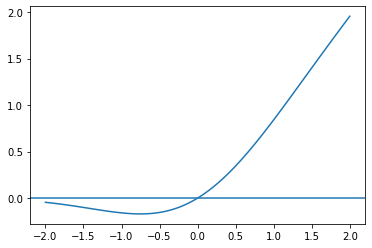

In [17]:
xx = torch.linspace(-2, 2, 100)
plt.plot(xx, f(xx))
plt.axhline(0)